In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
import pandas as pd
# import torch
# from transformers import BertTokenizer, BertModel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
import numpy as np
# import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
from helpers import (
    convert_percent_to_float, 
    get_bert_embedding, 
    _is_holiday,
    _region_to_country_code,
    _get_holiday_calendars,
    clean_currency,
    calculate_days_to_next
)

### Read Data

In [7]:
course_start_dts = ['2024-10-15', '2025-02-10', '2025-09-29', '2026-02-09']

In [8]:
# --- 1. Load 2024 Data (Standard xlsx) ---
df_2024 = pd.read_excel("Search keyword report (by Day 2024).xlsx")
df_2024['Day'] = pd.to_datetime(df_2024['Day'])

# --- 2. Load 2025 Data (Complex: UTF-16, Tab-separated, US Dates) ---
df_2025 = pd.read_csv(
    "Search keyword report (By day 2025).csv", 
    sep='\t', 
    encoding='utf-16', 
    dtype={'Day': str} # Prevent auto-parsing
)

# Fix Date: Force US format (Month/Day/Year) to prevent "Future Date" errors
df_2025['Day'] = pd.to_datetime(df_2025['Day'], dayfirst=False, errors='coerce')
df_2025 = df_2025.dropna(subset=['Day']) # Remove footer rows

# Apply cleaning to 2025 data using helper functions
cols_money = ['Cost', 'Avg. CPC', 'Conv. value']
for col in cols_money:
    df_2025[col] = df_2025[col].apply(clean_currency).replace('--', 0).astype(float)

# Clean Impressions (remove commas)
df_2025['Impr.'] = df_2025['Impr.'].astype(str).str.replace(',', '').replace('--', 0).astype(float)

# Clean CTR
df_2025['CTR'] = df_2025['CTR'].apply(convert_percent_to_float)

# --- 3. Combine & Calculate Profit ---
kw_df = pd.concat([df_2024, df_2025], ignore_index=True).sort_values('Day')
kw_df['profit'] = kw_df['Conv. value'] - kw_df['Cost']

# Verify
print(f"Data covers: {kw_df['Day'].min()} to {kw_df['Day'].max()}")

Data covers: 2024-07-05 00:00:00 to 2025-10-31 00:00:00


In [9]:
# Data formatting
kw_df['Campaign'] = kw_df['Campaign'].str.replace(r'\[.*?\]', '', regex=True)
kw_df['Region'] = kw_df['Campaign'].str.split('-').str[-1].str.strip()
kw_df['Region'] = kw_df['Region'].replace({'USA and CA': 'USA'})
kw_df['Keyword'] = kw_df['Keyword'].str.replace(r'["\[\]]', '', regex=True)
kw_df['Day'] = pd.to_datetime(kw_df['Day'])

kw_df = kw_df[['Day', 'Keyword', 'Match type', 'Region', 'Cost', 'Conv. value', 'Clicks']].copy()
kw_df.head()

,Day,Keyword,Match type,Region,Cost,Conv. value,Clicks
0,2024-07-05,artificial intelligence training,Phrase match,C,0.0,0.0,0
1,2024-07-05,AI for business,Phrase match,C,0.0,0.0,0
2,2024-07-05,google generative ai course,Phrase match,C,0.4,0.0,1
3,2024-07-05,google generative ai course,Exact match,C,0.0,0.0,0
4,2024-07-05,artificial intelligence for engineers,Phrase match,C,0.0,0.0,0


In [10]:
# Extract date features
# Assumes `course_start_dts` is defined earlier (list of ISO date strings) and
# `kw_df['Day']` is already datetime (we converted earlier).

# Basic date parts
kw_df['day_of_week'] = kw_df['Day'].dt.day_name()
kw_df['is_weekend'] = kw_df['Day'].dt.weekday >= 5
kw_df['month'] = kw_df['Day'].dt.month

# Map regions to country codes and build holiday calendars. Currently only using US holidays.
kw_df['_country_code'] = kw_df['Region'].apply(_region_to_country_code)
years_needed = sorted(set(kw_df['Day'].dt.year.dropna().astype(int).tolist()))
holiday_calendars = _get_holiday_calendars(kw_df['_country_code'].unique(), years=years_needed)

# Check if each day is a public holiday
kw_df['is_public_holiday'] = kw_df.apply(lambda row: _is_holiday(row, holiday_calendars), axis=1)

# Days to next course start date
kw_df['days_to_next_course_start'] = kw_df['Day'].apply(lambda d: calculate_days_to_next(d, course_start_dts))

# cleanup temporary helper column
if '_country_code' in kw_df.columns:
    kw_df.drop(columns=['_country_code'], inplace=True)

# show a quick sample to verify
kw_df[['Day','day_of_week','is_weekend','is_public_holiday','days_to_next_course_start']].head()

,Day,day_of_week,is_weekend,is_public_holiday,days_to_next_course_start
0,2024-07-05,Friday,False,0,102
1,2024-07-05,Friday,False,0,102
2,2024-07-05,Friday,False,0,102
3,2024-07-05,Friday,False,0,102
4,2024-07-05,Friday,False,0,102


### EDA

In [11]:
# Compute profit column if not already present
if 'profit' not in kw_df.columns:
    kw_df['profit'] = kw_df['Conv. value'] - kw_df['Cost']

# Resample to weekly average profit
# We reset_index() to make 'Day' a column again for Altair
weekly_profit = kw_df.set_index('Day').resample('W')['profit'].mean().reset_index()

# Create the interactive chart
chart = alt.Chart(weekly_profit).mark_line(point=True).encode(
    x=alt.X('Day', title='Date'),
    y=alt.Y('profit', title='Average Profit'),
    tooltip=[
        alt.Tooltip('Day', title='Date', format='%Y-%m-%d'),
        alt.Tooltip('profit', title='Average Profit', format='.2f')
    ]
).properties(
    title='Weekly Average Profit Over Time',
    width=800,
    height=400
).interactive()

chart

alt.Chart(...)

In [12]:
total_val = kw_df['Conv. value'].sum()
print(f"\nTotal Rows: {len(kw_df)}")
print(f"Total Conversion Value: ${total_val:,.2f}")


Total Rows: 81642
Total Conversion Value: $1,450,058.39


In [13]:
weekly_conv = kw_df.set_index('Day').resample('W', label='left')[['Conv. value', 'Cost', 'profit']].sum().reset_index()
weekly_conv.head(20)

,Day,Conv. value,Cost,profit
0,2024-06-30,0.00,495.29,-495.29
1,2024-07-07,0.00,12351.73,-12351.73
2,2024-07-14,0.00,11083.20,-11083.20
3,2024-07-21,0.00,8986.31,-8986.31
4,2024-07-28,1.00,9208.46,-9207.46
5,2024-08-04,1.00,8761.65,-8760.65
6,2024-08-11,922.10,10141.89,-9219.79
7,2024-08-18,66.01,9998.43,-9932.42
8,2024-08-25,4971.20,8770.10,-3798.90
9,2024-09-01,2759.09,10337.69,-7578.60


In [14]:
# From the chart above, remove all values before 2024-11-03
kw_df = kw_df[kw_df['Day'] >= '2024-11-03'].copy()

In [15]:
print("Dataset shape:", kw_df.shape)
print("\nData types:")
print(kw_df.dtypes)
print("\nMissing values:")
print(kw_df.isnull().sum())
print("\nBasic statistics:")
print(kw_df.describe())

Dataset shape: (45699, 13)

Data types:
Day                          datetime64[ns]
Keyword                              object
Match type                           object
Region                               object
Cost                                float64
Conv. value                         float64
Clicks                                int64
day_of_week                          object
is_weekend                             bool
month                                 int64
is_public_holiday                     int64
days_to_next_course_start             int64
profit                              float64
dtype: object

Missing values:
Day                          0
Keyword                      0
Match type                   0
Region                       0
Cost                         0
Conv. value                  0
Clicks                       0
day_of_week                  0
is_weekend                   0
month                        0
is_public_holiday            0
days_to_next_cou

In [16]:
# Categorical columns analysis
print("Unique values per categorical column:")
print(f"Keywords: {kw_df['Keyword'].nunique()}")
print(f"Match types: {kw_df['Match type'].nunique()}")
print(f"Regions: {kw_df['Region'].nunique()}")
print(f"\nMatch type distribution:")
print(kw_df['Match type'].value_counts())
print(f"\nRegion distribution:")
print(kw_df['Region'].value_counts())

Unique values per categorical column:
Keywords: 187
Match types: 3
Regions: 4

Match type distribution:
Exact match     21054
Phrase match    19269
Broad match      5376
Name: Match type, dtype: int64

Region distribution:
USA    19060
A      10991
B      10742
C       4906
Name: Region, dtype: int64


In [17]:
# EDA - Date feature summaries
print('--- Date feature summaries ---')

# day_of_week distribution
if 'day_of_week' in kw_df.columns:
    print('\nDay of week distribution:')
    print(kw_df['day_of_week'].value_counts(dropna=False))
else:
    print('\nColumn day_of_week not found')

# is_weekend counts
if 'is_weekend' in kw_df.columns:
    print('\nIs weekend counts:')
    print(kw_df['is_weekend'].value_counts(dropna=False))

# month distribution (derive month_name from Day when needed)
if 'month' in kw_df.columns:
    print('\nMonth distribution (month number -> name):')
    # ensure we have a month integer series
    month_series = kw_df['month'].fillna(kw_df['Day'].dt.month).astype(int)
    # get month names either from existing column or from Day
    if 'month_name' in kw_df.columns:
        month_name_series = kw_df['month_name']
    else:
        month_name_series = kw_df['Day'].dt.month_name()
    month_order = pd.DataFrame({'month': month_series, 'month_name': month_name_series}).drop_duplicates().set_index('month')['month_name'].sort_index()
    counts_by_month = month_series.value_counts().reindex(month_order.index).fillna(0).astype(int)
    for m, name in month_order.items():
        print(f"{m:02d} {name}: {counts_by_month.get(m,0)}")

# public holiday counts and by-region rate
if 'is_public_holiday' in kw_df.columns:
    print('\nPublic holiday counts:')
    print(kw_df['is_public_holiday'].value_counts(dropna=False))
    if 'Region' in kw_df.columns:
        print('\nPublic holiday rate by Region (proportion of rows that are holidays):')
        print(kw_df.groupby('Region')['is_public_holiday'].mean().sort_values(ascending=False))

# days to next course start - summary and simple buckets
if 'days_to_next_course_start' in kw_df.columns:
    print('\nDays to next course start - summary:')
    print(kw_df['days_to_next_course_start'].describe())
    nulls = kw_df['days_to_next_course_start'].isnull().sum()
    print(f"Null / no future start count: {nulls}")
    # simple buckets
    print('\nDays to next start - buckets:')
    bins = [-1,0,7,30,90,180,365,10_000]
    labels = ['past_or_today','0-7d','8-30d','31-90d','91-180d','181-365d','>365d']
    try:
        b = pd.cut(kw_df['days_to_next_course_start'].fillna(-1), bins=bins, labels=labels)
        print(b.value_counts().reindex(labels))
    except Exception as e:
        print('Could not create buckets:', e)

print('\n--- End date feature summaries ---')

--- Date feature summaries ---

Day of week distribution:
Monday       7039
Tuesday      6724
Wednesday    6662
Sunday       6504
Thursday     6417
Friday       6358
Saturday     5995
Name: day_of_week, dtype: int64

Is weekend counts:
False    33200
True     12499
Name: is_weekend, dtype: int64

Month distribution (month number -> name):
01 January: 9289
02 February: 4169
03 March: 3101
04 April: 309
06 June: 1578
07 July: 2759
08 August: 2430
09 September: 1965
10 October: 1494
11 November: 8950
12 December: 9655

Public holiday counts:
0    43973
1     1726
Name: is_public_holiday, dtype: int64

Public holiday rate by Region (proportion of rows that are holidays):
Region
C      0.044232
B      0.040123
A      0.037940
USA    0.034680
Name: is_public_holiday, dtype: float64

Days to next course start - summary:
count    45699.000000
mean        69.957986
std         54.529332
min          0.000000
25%         31.000000
50%         61.000000
75%         88.000000
max        221.000000

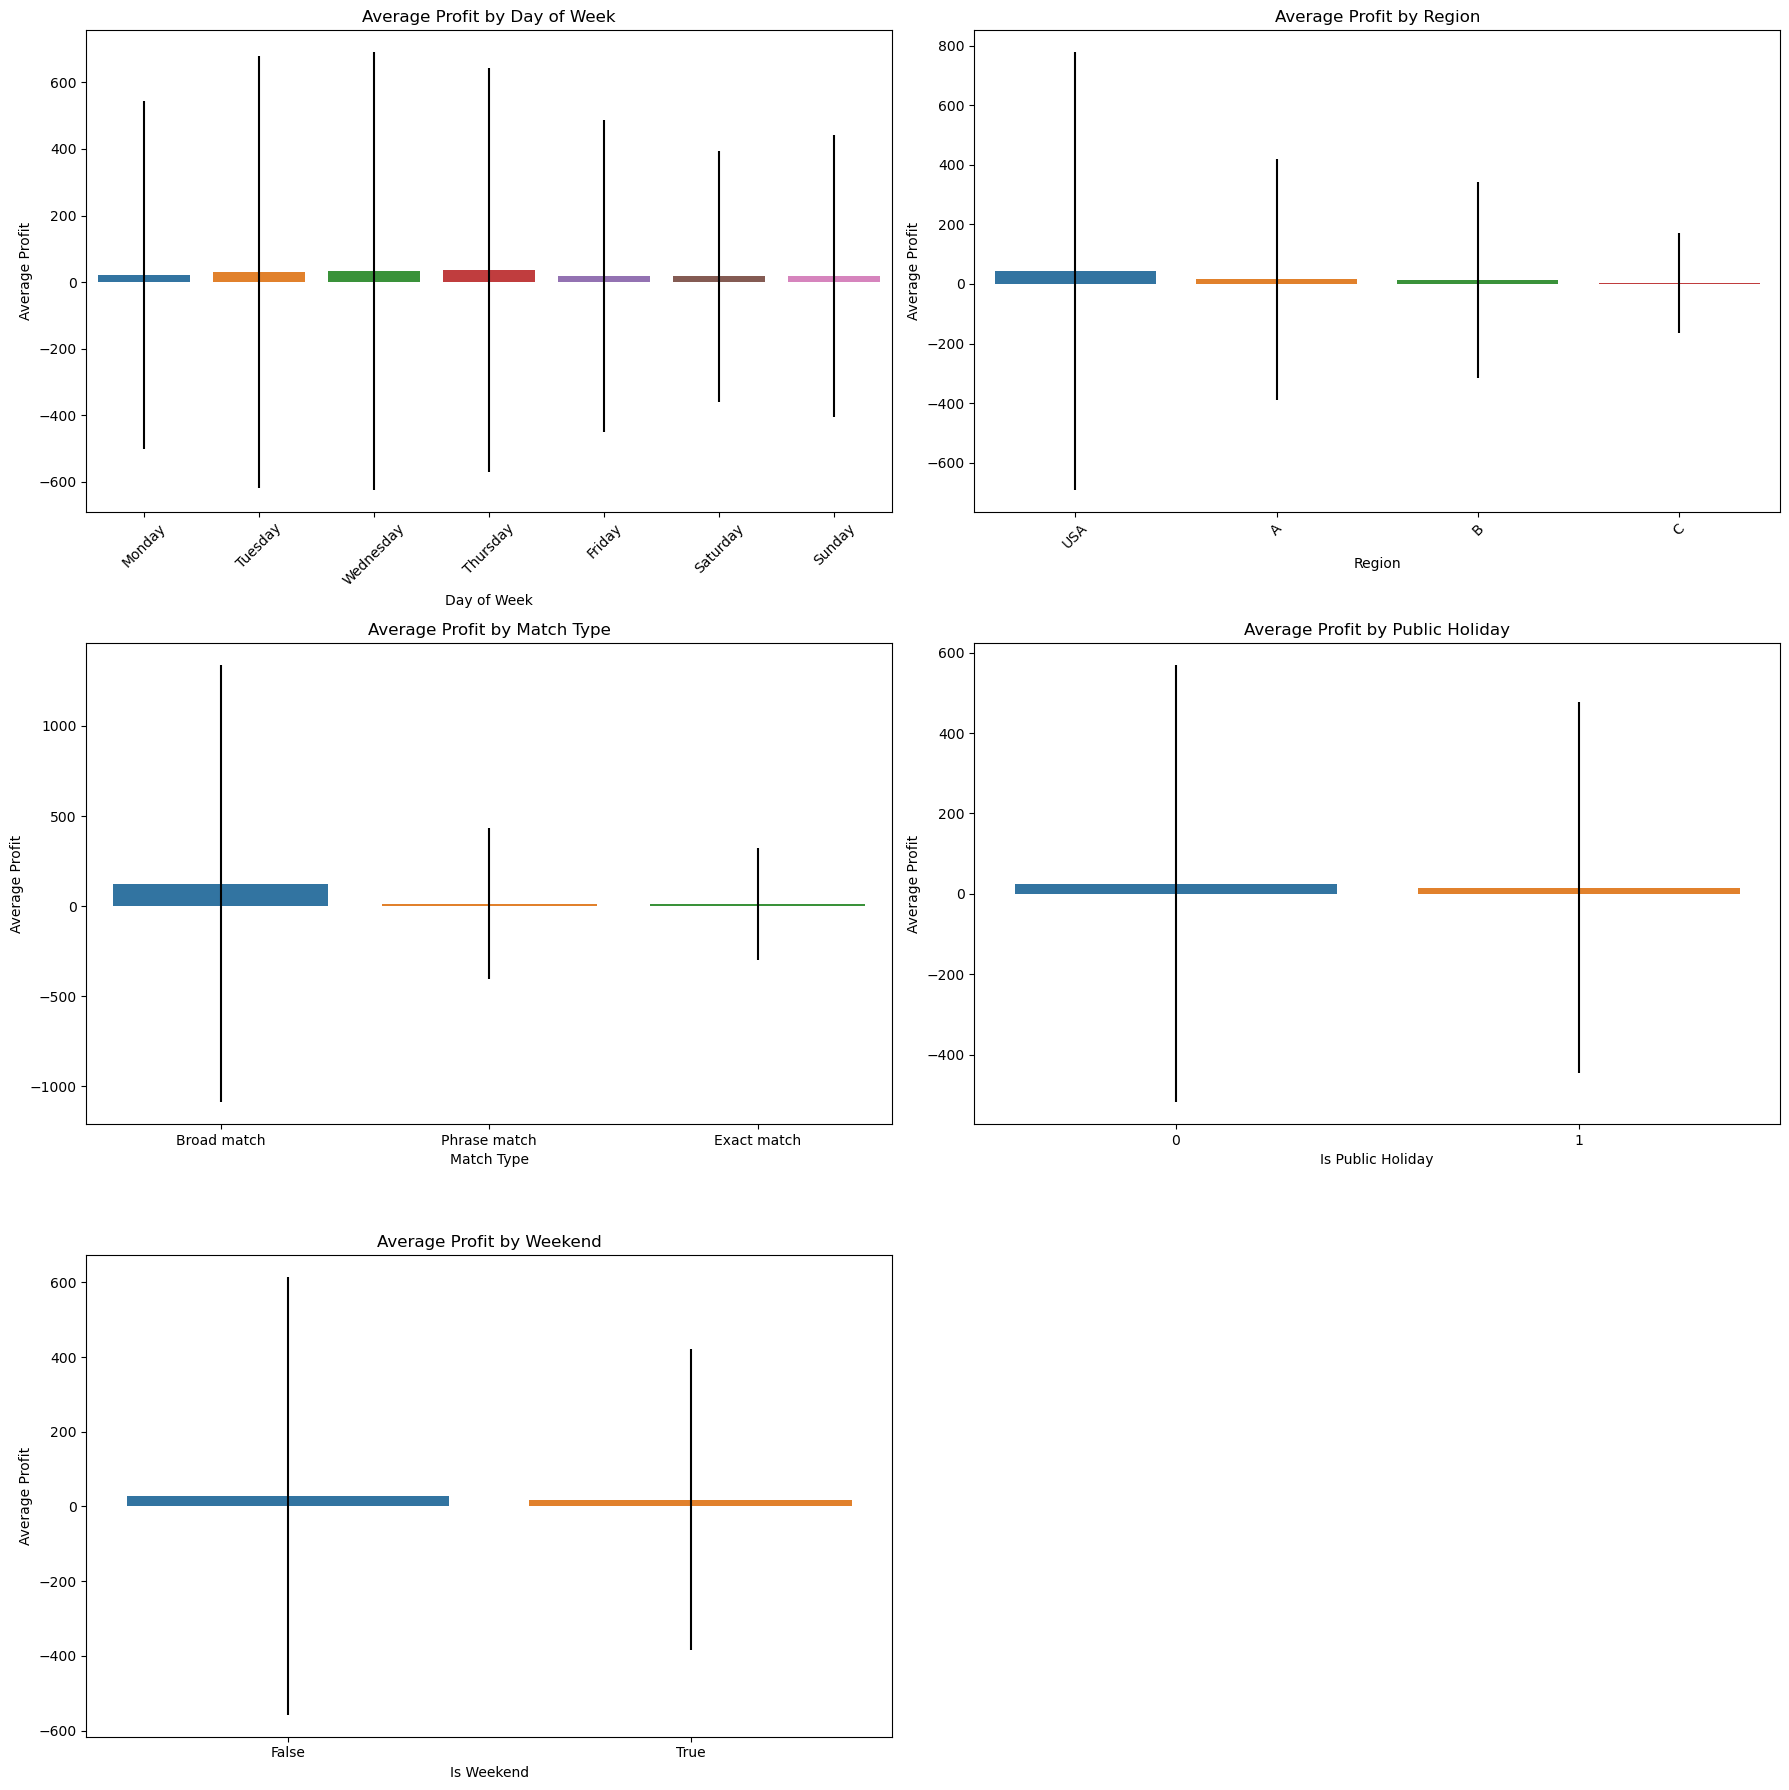

In [20]:
# EDA: Plot average (Conv. value - Cost) by day of week, region, match type, public holiday, and weekend, with optional standard deviation error bars
show_std = True  # Set to False to hide standard deviation error bars

plt.figure(figsize=(18, 18))

# 1. By day of week (bar plot)
plt.subplot(3, 2, 1)
dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_stats = kw_df.groupby('day_of_week')['profit'].agg(['mean', 'std']).reindex(dow_order)
if show_std:
    sns.barplot(x=dow_stats.index, y=dow_stats['mean'], yerr=dow_stats['std'], capsize=0.2)
else:
    sns.barplot(x=dow_stats.index, y=dow_stats['mean'])
plt.title('Average Profit by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Profit')
plt.xticks(rotation=45)

# 2. By region (bar plot)
plt.subplot(3, 2, 2)
region_stats = kw_df.groupby('Region')['profit'].agg(['mean', 'std']).sort_values('mean', ascending=False)
if show_std:
    sns.barplot(x=region_stats.index, y=region_stats['mean'], yerr=region_stats['std'], capsize=0.2)
else:
    sns.barplot(x=region_stats.index, y=region_stats['mean'])
plt.title('Average Profit by Region')
plt.xlabel('Region')
plt.ylabel('Average Profit')
plt.xticks(rotation=45)

# 3. By match type (bar plot)
plt.subplot(3, 2, 3)
match_stats = kw_df.groupby('Match type')['profit'].agg(['mean', 'std']).sort_values('mean', ascending=False)
if show_std:
    sns.barplot(x=match_stats.index, y=match_stats['mean'], yerr=match_stats['std'], capsize=0.2)
else:
    sns.barplot(x=match_stats.index, y=match_stats['mean'])
plt.title('Average Profit by Match Type')
plt.xlabel('Match Type')
plt.ylabel('Average Profit')

# 4. By public holiday (bar plot)
plt.subplot(3, 2, 4)
if 'is_public_holiday' in kw_df.columns:
    holiday_stats = kw_df.groupby('is_public_holiday')['profit'].agg(['mean', 'std'])
    if show_std:
        sns.barplot(x=holiday_stats.index.astype(str), y=holiday_stats['mean'], yerr=holiday_stats['std'], capsize=0.2)
    else:
        sns.barplot(x=holiday_stats.index.astype(str), y=holiday_stats['mean'])
    plt.title('Average Profit by Public Holiday')
    plt.xlabel('Is Public Holiday')
    plt.ylabel('Average Profit')
else:
    plt.text(0.5, 0.5, 'No public holiday data', ha='center', va='center')
    plt.axis('off')

# 5. By weekend (bar plot)
plt.subplot(3, 2, 5)
if 'is_weekend' in kw_df.columns:
    weekend_stats = kw_df.groupby('is_weekend')['profit'].agg(['mean', 'std'])
    if show_std:
        sns.barplot(x=weekend_stats.index.astype(str), y=weekend_stats['mean'], yerr=weekend_stats['std'], capsize=0.2)
    else:
        sns.barplot(x=weekend_stats.index.astype(str), y=weekend_stats['mean'])
    plt.title('Average Profit by Weekend')
    plt.xlabel('Is Weekend')
    plt.ylabel('Average Profit')
else:
    plt.text(0.5, 0.5, 'No weekend data', ha='center', va='center')
    plt.axis('off')

plt.tight_layout()
plt.show()

### Generate new keywords
***
Currently done manually - either through Google keyword planner (just with website input) or with Gemini (with the web page html and existing keywords as input).

In [21]:
new_gemini = pd.read_csv('new_keywords_gemini2.csv')  # New keywords from Gemini
new_gkp = pd.read_csv('new_keywords_gkp.csv')  # New keywords from Google Keyword Planner
# kw_df['Keyword'].drop_duplicates().to_csv('unique_keywords.csv', index=False) # Save existing keywords. Should make all lower case before dropping duplicates.

In [22]:
# Combine existing and new keywords with origin tracking
# Read existing keywords
existing_kw = pd.read_csv('unique_keywords.csv')
existing_kw['origin'] = 'existing'

# Add origin column to new keywords
new_gemini['origin'] = 'gemini'
new_gkp['origin'] = 'gkp'

# Get the Keyword column from each dataframe
existing_kw['Keyword'] = existing_kw['Keyword'].str.lower()
existing_kw = existing_kw.drop_duplicates(subset=['Keyword']).reset_index(drop=True)
existing_set = set(existing_kw['Keyword'])
gemini_kw = new_gemini[~new_gemini['Keyword'].str.lower().isin(existing_set)].copy()
gkp_kw = new_gkp[~new_gkp['Keyword'].str.lower().isin(existing_set)].copy()

# Combine all keywords
all_keywords = pd.concat([existing_kw, gemini_kw, gkp_kw], ignore_index=True)

print(f"Total unique keywords: {len(all_keywords)}")
print(f"  - Existing: {(all_keywords['origin'] == 'existing').sum()}")
print(f"  - Gemini (new): {(all_keywords['origin'] == 'gemini').sum()}")
print(f"  - GKP (new): {(all_keywords['origin'] == 'gkp').sum()}")
print("\nSample of combined keywords:")
print(all_keywords.head(10))

Total unique keywords: 630
  - Existing: 184
  - Gemini (new): 98
  - GKP (new): 348

Sample of combined keywords:
                             Keyword    origin
0   generative ai foundations course  existing
1  generative ai certificate program  existing
2       generative ai online program  existing
3        generative ai online course  existing
4  generative ai fundamentals course  existing
5   generative ai certificate course  existing
6           generative ai course mit  existing
7               generative ai course  existing
8            learn how to program ai  existing
9               ai generated courses  existing


In [23]:
# all_keywords.to_csv('combined_keywords.csv', index=False)

### Get Ads data
***
TO DO:
- Add other features from keyword planner API.
- Think about how to handle NAs and new keywords.

In [18]:
ad_data = pd.read_csv('combined_kw_ads_data2.csv')

In [19]:
# --- Prepare the merge key in both dataframes ---
# It's crucial to clean them (lowercase, strip whitespace) for matching
# We'll create a new temporary column 'Keyword_clean' for the merge

kw_df['Keyword_clean'] = kw_df['Keyword'].str.lower().str.strip()
ad_data['Keyword_clean'] = ad_data['Keyword'].str.lower().str.strip()

# Check for duplicate keywords in the ad_data_df, which could cause issues
if ad_data['Keyword_clean'].duplicated().any():
    print("\nWarning: Duplicate keywords found in ad_data_df. Dropping duplicates, keeping first entry.")
    ad_data = ad_data.drop_duplicates(subset=['Keyword_clean'])

# --- Perform the merge ---
# We'll use a left merge. This keeps every row from your original kw_df
# and adds the columns from ad_data_df where the 'Keyword_clean' matches.

# We will merge on the clean key.
# We also need to drop the *original* 'Keyword' column from the ad_data_df
# to avoid having a 'Keyword_x' and 'Keyword_y' in the final result.
ad_data_to_merge = ad_data.drop(columns=['Keyword'], errors='ignore')

merged_df = pd.merge(
    kw_df,
    ad_data_to_merge,
    on='Keyword_clean',
    how='left'
)

# Now we can drop the temporary 'Keyword_clean' column
merged_df = merged_df.drop(columns=['Keyword_clean'], errors='ignore')

print("\n--- Merged DataFrame Head (First 5 Rows) ---")
print(merged_df.head())

print("\n--- Merged DataFrame Info (shows new columns) ---")
# This info will show the new columns added from ad_data_df
merged_df.info()


--- Merged DataFrame Head (First 5 Rows) ---
         Day                                      Keyword    Match type  \
0 2024-11-03                     mit generative ai course   Exact match   
1 2024-11-03    certification for artificial intelligence  Phrase match   
2 2024-11-03  best place to study artificial intelligence  Phrase match   
3 2024-11-03                generative ai training course  Phrase match   
4 2024-11-03                  google generative ai course  Phrase match   

  Region  Cost  Conv. value  Clicks day_of_week  is_weekend  month  \
0    USA  0.00          0.0       0      Sunday        True     11   
1      C  0.00          0.0       0      Sunday        True     11   
2      C  0.00          0.0       0      Sunday        True     11   
3      C  0.36          0.0       1      Sunday        True     11   
4      C  0.00          0.0       0      Sunday        True     11   

   is_public_holiday  days_to_next_course_start  profit  \
0                  0   

In [20]:
# Drop NAs
# Define the subset of columns to check for NaNs
# These are the columns from the ad_data file
subset_cols = [
    'Avg. monthly searches',
    'Three month change',
    'YoY change',
    'Competition',
    'Competition (indexed value)',
    'Top of page bid (low range)',
    'Top of page bid (high range)'
]

# Drop rows where *any* of the columns in subset_cols are NaN
cleaned_df = merged_df.dropna(subset=subset_cols, how='any').copy()

# Report the results
rows_dropped = merged_df.shape[0] - cleaned_df.shape[0]
print(f"Dropped {rows_dropped} rows.")
print(f"New shape after dropping NaNs: {cleaned_df.shape}")

Dropped 5889 rows.
New shape after dropping NaNs: (39810, 20)


In [21]:
# Apply the function to the columns
cleaned_df['Three month change'] = cleaned_df['Three month change'].apply(convert_percent_to_float)
cleaned_df['YoY change'] = cleaned_df['YoY change'].apply(convert_percent_to_float)
cleaned_df['avg_bid'] = (cleaned_df['Top of page bid (low range)'] + cleaned_df['Top of page bid (high range)']) / 2

In [22]:
cleaned_df

,Day,Keyword,Match type,Region,Cost,Conv. value,Clicks,day_of_week,is_weekend,month,...,days_to_next_course_start,profit,Avg. monthly searches,Three month change,YoY change,Competition,Competition (indexed value),Top of page bid (low range),Top of page bid (high range),avg_bid
0,2024-11-03,mit generative ai course,Exact match,USA,0.00,0.0,0,Sunday,True,11,...,99,0.00,500.0,0.0,0.0,High,86.0,4.69,16.84,10.765
1,2024-11-03,certification for artificial intelligence,Phrase match,C,0.00,0.0,0,Sunday,True,11,...,99,0.00,5000.0,0.0,0.0,High,88.0,4.46,14.95,9.705
2,2024-11-03,best place to study artificial intelligence,Phrase match,C,0.00,0.0,0,Sunday,True,11,...,99,0.00,50.0,0.0,0.0,High,94.0,6.31,16.20,11.255
3,2024-11-03,generative ai training course,Phrase match,C,0.36,0.0,1,Sunday,True,11,...,99,-0.36,50.0,0.0,0.0,High,83.0,5.00,15.39,10.195
4,2024-11-03,google generative ai course,Phrase match,C,0.00,0.0,0,Sunday,True,11,...,99,0.00,500.0,0.0,-0.9,Medium,63.0,2.05,7.31,4.680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45692,2025-10-31,online generative AI course,Phrase match,USA,0.00,0.0,0,Friday,False,10,...,101,0.00,50.0,0.0,0.0,Medium,62.0,4.88,12.25,8.565
45693,2025-10-31,MIT xPRO AI course,Exact match,USA,0.00,0.0,0,Friday,False,10,...,101,0.00,500.0,0.0,9.0,High,83.0,6.08,23.78,14.930
45695,2025-10-31,prompt engineering course,Phrase match,USA,0.00,0.0,0,Friday,False,10,...,101,0.00,5000.0,0.0,0.0,High,85.0,3.63,11.26,7.445
45696,2025-10-31,professional certificate in AI,Phrase match,USA,0.00,0.0,0,Friday,False,10,...,101,0.00,50.0,0.0,0.0,High,92.0,6.21,19.23,12.720


In [39]:
# Get TD-IDF embeddings
# Get the unique keywords to avoid redundant processing
# (Your data has ~71k rows but only ~141 unique keywords)
unique_keywords = cleaned_df['Keyword'].unique()
print(f"Processing {len(unique_keywords)} unique keywords...")

# --- 2. Load TF-IDF vectorizer ---
# tweak ngram_range etc. for short phrases
vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),  # unigrams + bigrams often help with short phrases
    min_df=1             # keep all terms (you can increase this to prune rare terms)
)

# --- 3a. Fit on all unique keywords and transform
X_tfidf = vectorizer.fit_transform(unique_keywords)


# --- 4. Reduce to 50 dimensions with TruncatedSVD ---
n_components = 50  # target embedding dimension
svd = TruncatedSVD(
    n_components=n_components,
    random_state=42
)
X_svd = svd.fit_transform(X_tfidf)

# --- 5. Map Embeddings Back to DataFrame ---
embedding_df = pd.DataFrame(
    X_svd,
    columns=[f"tfidf_{i}" for i in range(n_components)]
)
embedding_df['Keyword'] = unique_keywords
df = cleaned_df.merge(embedding_df, on='Keyword', how='left')

Processing 146 unique keywords...


In [42]:
df.shape

(39810, 71)

In [43]:
df.to_csv('data/ad_opt_data_tfidf.csv', index=False)

In [49]:
from sklearn.model_selection import train_test_split

features = ['Match type', 'Region', 'day_of_week', 'is_weekend', 'month', 'is_public_holiday', \
     'days_to_next_course_start'] + \
     [col for col in df.columns if 'tfidf' in col]
X = df[features]
y = df[['Conv. value', 'Clicks']]

In [58]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

In [59]:
np.mean(y_train)

/Users/seehanahtang/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Conv. value    30.098523
Clicks          1.368892
dtype: float64

In [67]:
df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

df_train.to_csv("data/train_tfidf.csv", index=False)
df_test.to_csv("data/test_tfidf.csv", index=False)